## Conversion Rate Analysis and Prediction

### Importing Necessary Libraries

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

%matplotlib inline

### Loading and Exploring the Dataset

In [2]:
data = pd.read_csv('C:/Users/Victor/OneDrive - The University of Texas at Austin/Documents/Take Home Challenge/1.conversion/conversion_data.csv')
data.head()
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


### Visualizing Data Distribution

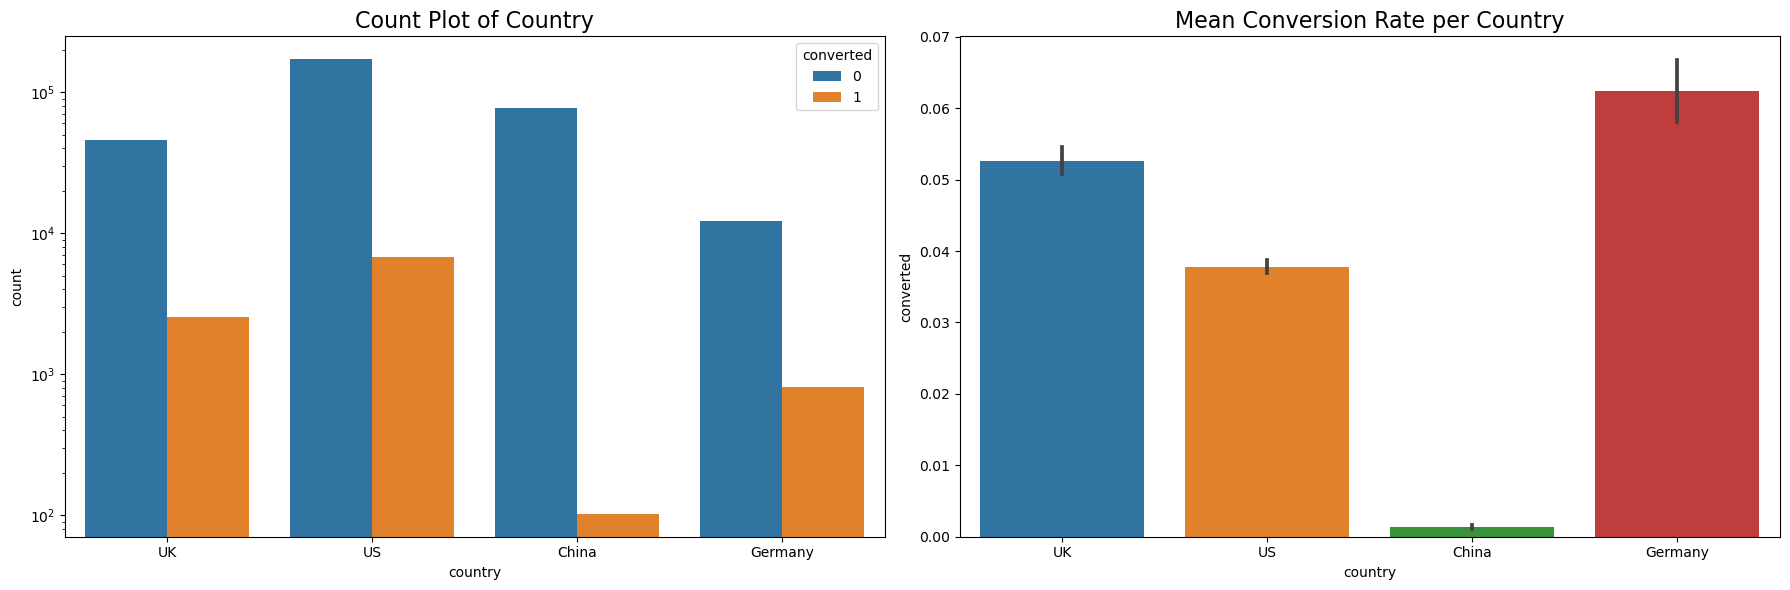

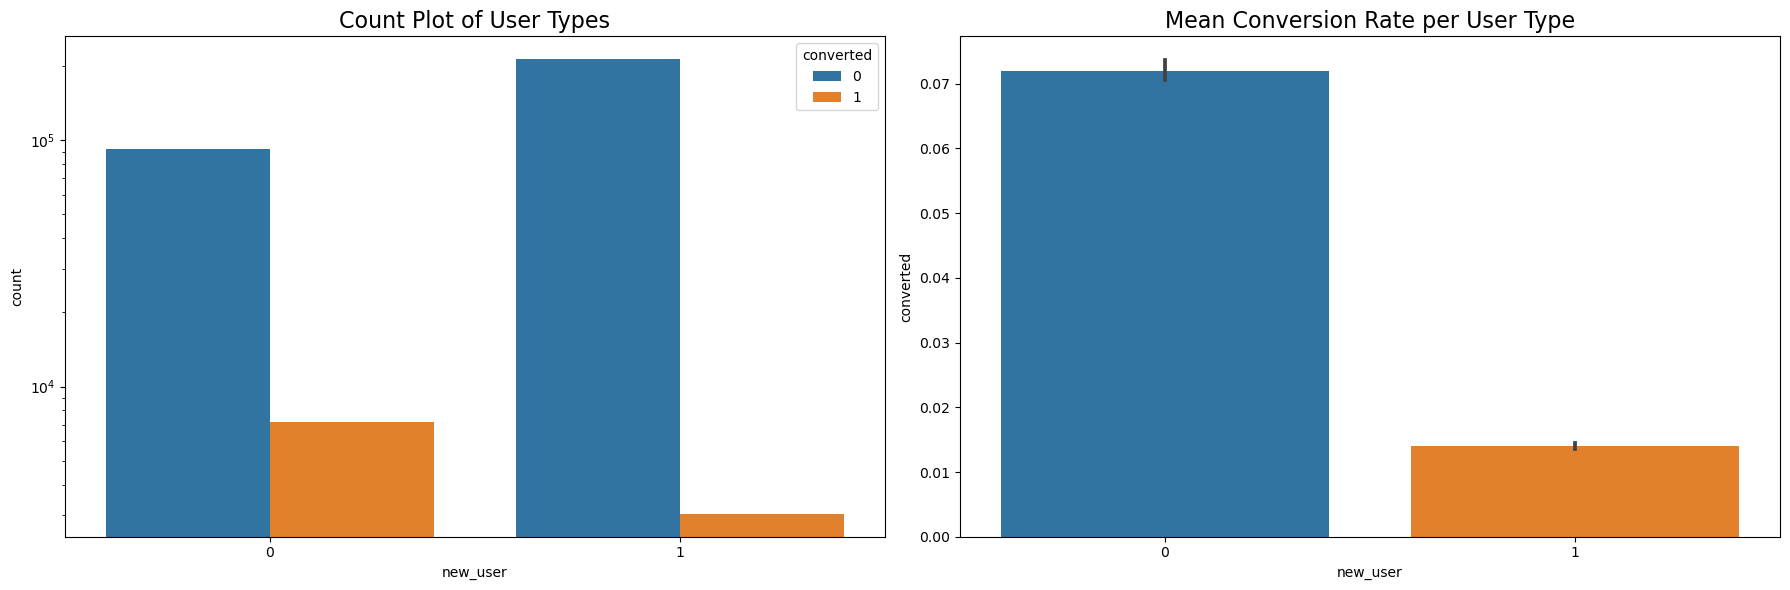

In [3]:
data[data['age'] > 90]
data = data[data['age'] < 100]
# Visualization of different countries
grouped = data[['country', 'converted']].groupby('country').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='country', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='country', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Country', fontsize=16)
plt.tight_layout()
plt.show()
# Visualization of different user types
grouped = data[['new_user', 'converted']].groupby('new_user').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='new_user', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of User Types', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='new_user', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per User Type', fontsize=16)
plt.tight_layout()
plt.show()

### Data Preprocessing & Feature Engineering

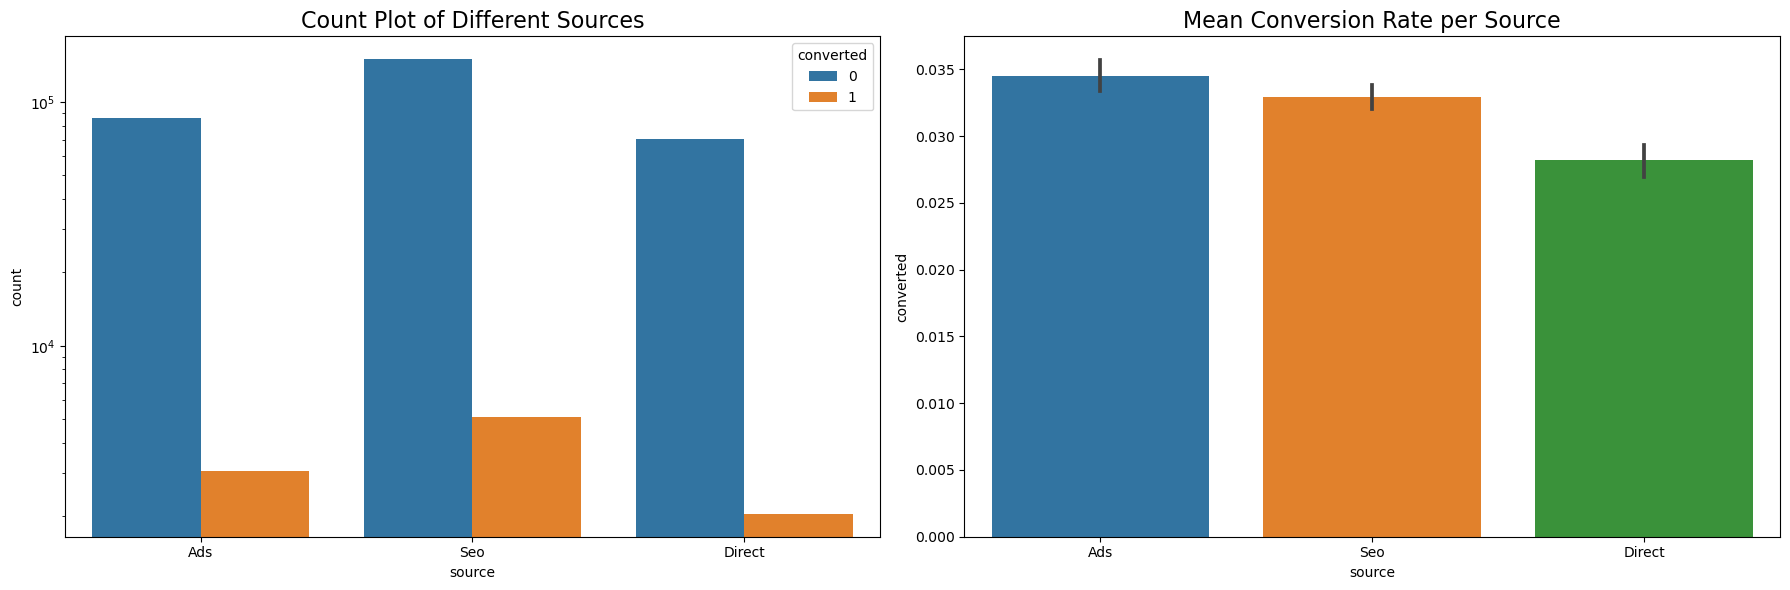

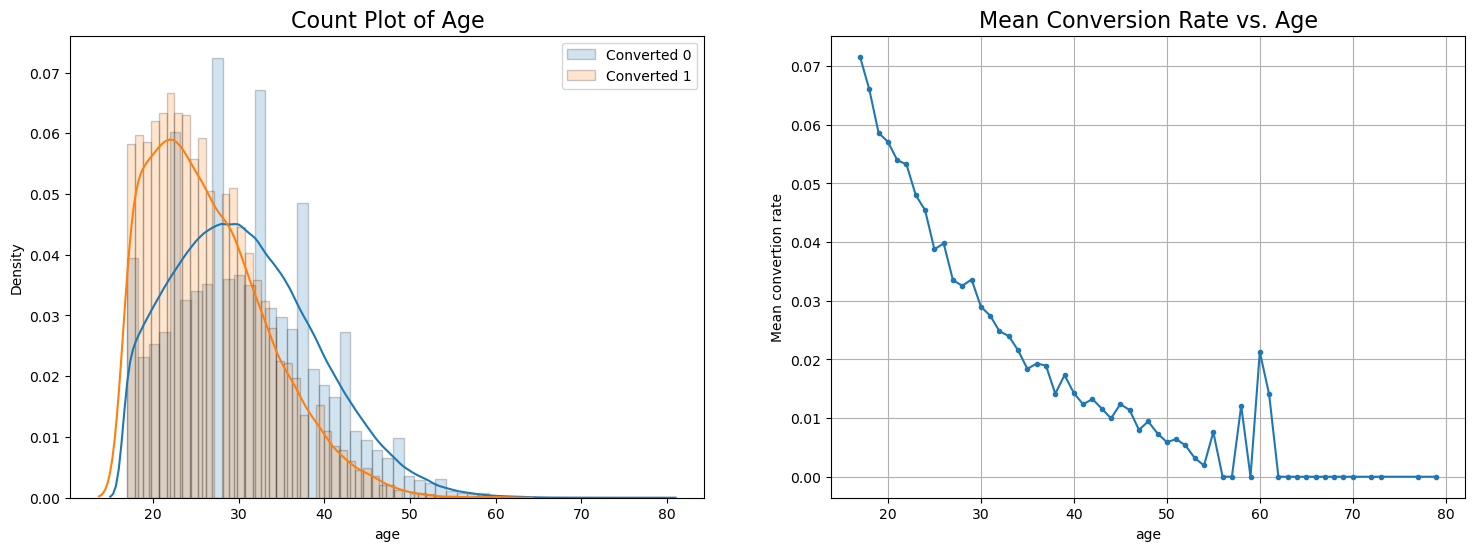

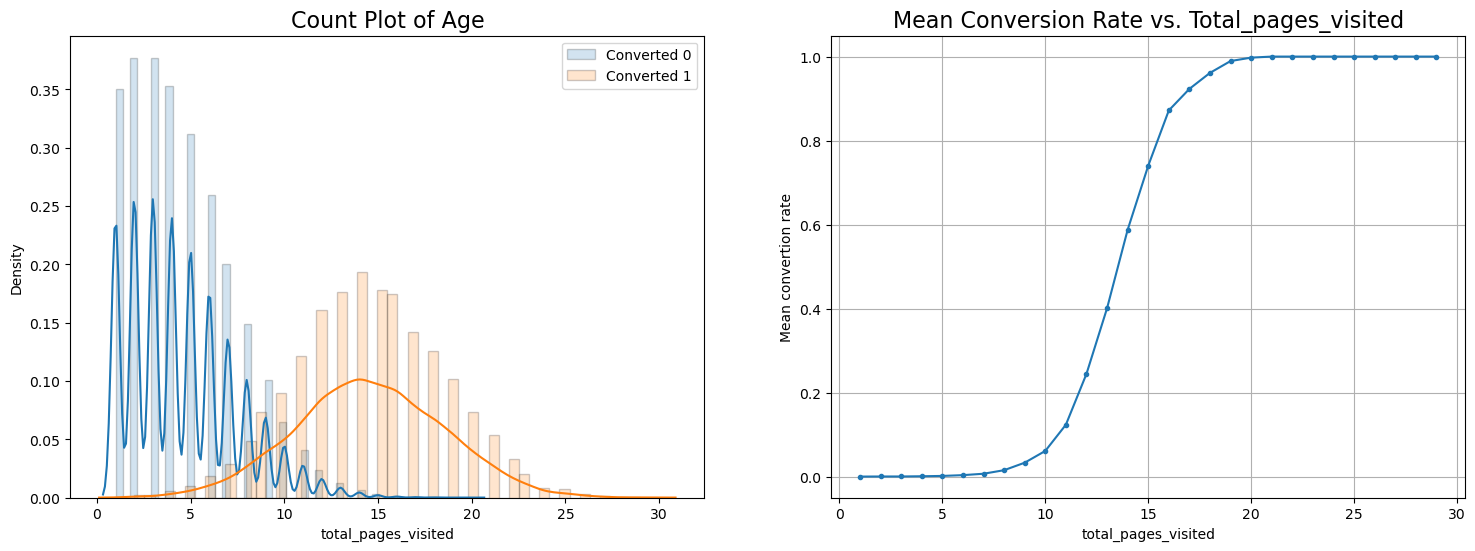

In [4]:
# Visualization of different sources
grouped = data[['source', 'converted']].groupby('source').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='source', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Different Sources', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='source', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Source', fontsize=16)
plt.tight_layout()
plt.show()
# Visualization of different sources
grouped = data[['age', 'converted']].groupby('age').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['converted'] == 0]['age'], label='Converted 0', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted'] == 1]['age'], label='Converted 1', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['age'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Age', fontsize=16)
ax[1].set_xlabel('age')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()
# Visualization of different sources
grouped = data[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['converted'] == 0]['total_pages_visited'], 
             label='Converted 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted'] == 1]['total_pages_visited'], 
             label='Converted 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['total_pages_visited'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Total_pages_visited', fontsize=16)
ax[1].set_xlabel('total_pages_visited')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

### Logistic Regression Model

In [5]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(data)

h2o_df['new_user'] = h2o_df['new_user'].asfactor()
h2o_df['converted'] = h2o_df['converted'].asfactor()

h2o_df.summary()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 20.0.2+9-78, mixed mode, sharing)
  Starting server from C:\Users\Victor\Anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Victor\AppData\Local\Temp\tmp0_x8_70o
  JVM stdout: C:\Users\Victor\AppData\Local\Temp\tmp0_x8_70o\h2o_Victor_started_from_python.out
  JVM stderr: C:\Users\Victor\AppData\Local\Temp\tmp0_x8_70o\h2o_Victor_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Toronto
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.2
H2O_cluster_version_age:,20 days
H2O_cluster_name:,H2O_from_python_Victor_379lxg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.188 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


C:\Users\Victor\AppData\Local\Temp\ipykernel_20884\4181115627.py:10: H2ODeprecationWarning: ``summary()`` is deprecated, please use ``show_summary()`` or ``get_summary()`` instead
  h2o_df.summary()


,country,age,new_user,source,total_pages_visited,converted
type,enum,int,enum,enum,int,enum
mins,,17.0,,,1.0,
mean,,30.5693110013347,,,4.872918234777034,
maxs,,79.0,,,29.0,
sigma,,8.268957596421474,,,3.3410533442156267,
zeros,,0,,,0,
missing,0,0,0,0,0,0
0,UK,25.0,1,Ads,1.0,0
1,US,23.0,1,Seo,5.0,0
2,US,28.0,1,Seo,4.0,0


### Random Forest Model

In [6]:
# Split into 75% training and 25% test dataset
strat_split = h2o_df['converted'].stratified_split(test_frac=0.25, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target = 'converted'
# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1692037207615_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    100                100                         3.19267e+06            19           20           19.95         1639          3021          2533.32

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.11696721377442372
RMSE: 0.3420046984683452
LogLoss: 0.3738739129423283
Mean Per-Class Error: 0.04081435293829069
AUC: 0.9928795886022057
AUCPR: 0.9916254191447307
Gini: 0.9857591772044114

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.02768684877408744
       0       1       Error    Rate
-----  ------  ------  -------  ------------------
0      216848  12652   0.0551   (12652.0/229500.0)
1      6082    223426  0.0265   (6082.0/229508.0)
Total  222930  236078  0.0408   (18734.0/459008.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0276868    0.959763  377
max f2                       0.00953866   0.97753   388
max f0point5                 0.0914737    0.962071  349
max accuracy                 0.0301186    0.959199  376
max precision                0.989085     0.99926   7
max recall                   0.0024902    1         394
max specificity              0.999518     0.999987  0
max absolute_mcc             0.0276868    0.918748  377
max min_per_class_accuracy   0.0437648    0.957978  370
max mean_per_class_accuracy  0.0301186    0.959199  376
max tns                      0.999518     229497    0
max fns                      0.999518     228584    0
max fps                      7.81305e-05  229500    399
max tps                      0.0024902    229508    394
max tnr                      0.999518     0.999987  0
max fnr                      0.999518     0.995974  0
max fpr                      7.81305e-05  1         399
max tpr                      0.0024902    1         394

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 32.08 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.010002                    0.994116           1.99735   1.99735            0.998693         0.996718     0.998693                    0.996718            0.0199775       0.0199775                  99.7351   99.7351            0.0199514
2        0.0200018                   0.99069            1.99909   1.99822            0.999564         0.99239      0.999129                    0.994555            0.0199906       0.0399681                  99.9094   99.8222            0.0399332
3        0.0300017                   0.987011           1.99866   1.99837            0.999346         0.988903     0.999201                    0.992671            0.0199862       0.0599543                  99.8658   99.8368            0.0599064
4        0.0400015                   0.981569           1.99735   1.99811            0.998693         0.984477     0.999074                    0.990622            0.0199732       0.0799275                  99.7351   99.8113            0.0798534
5        0.0500013                   0.974624           1.99779   1.99805            0.998911      

### Gradient Boosting Machine (GBM) Model

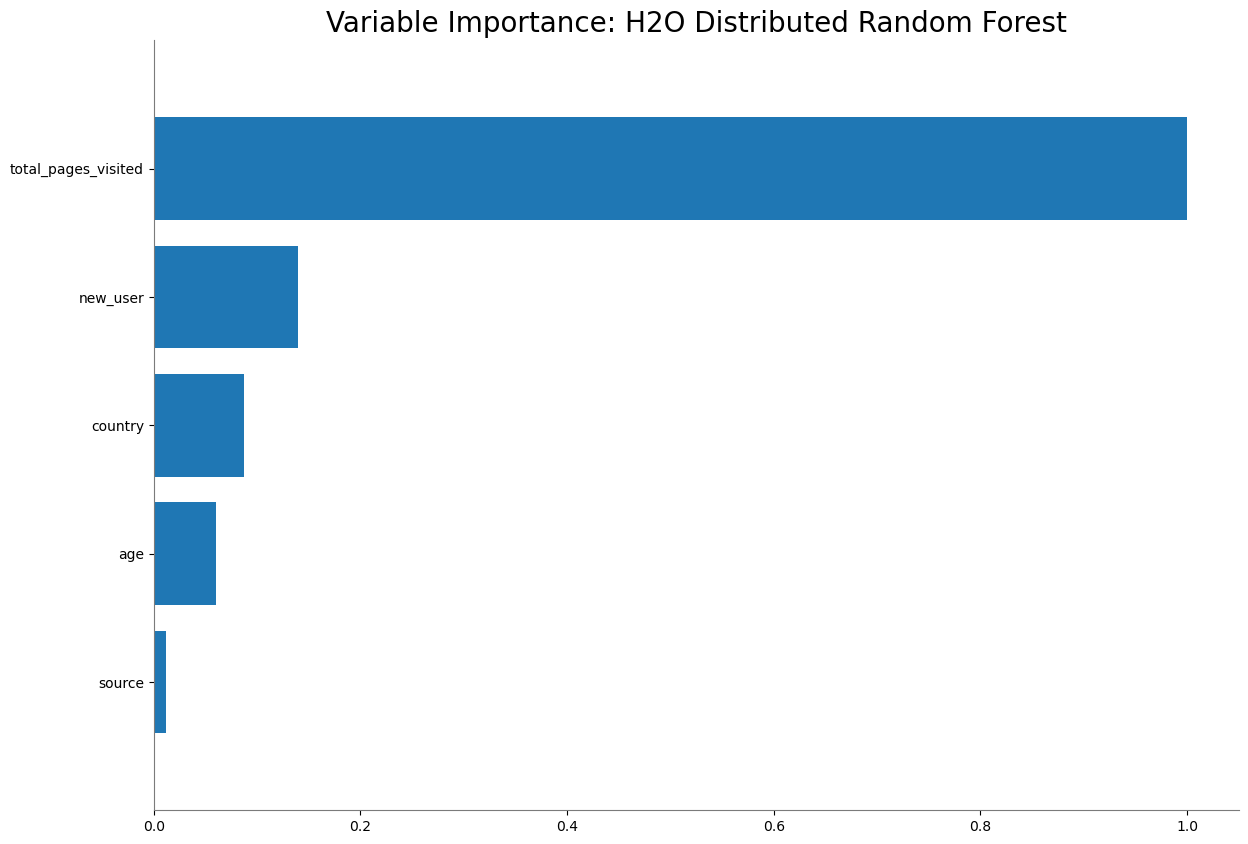

<Figure size 640x480 with 0 Axes>

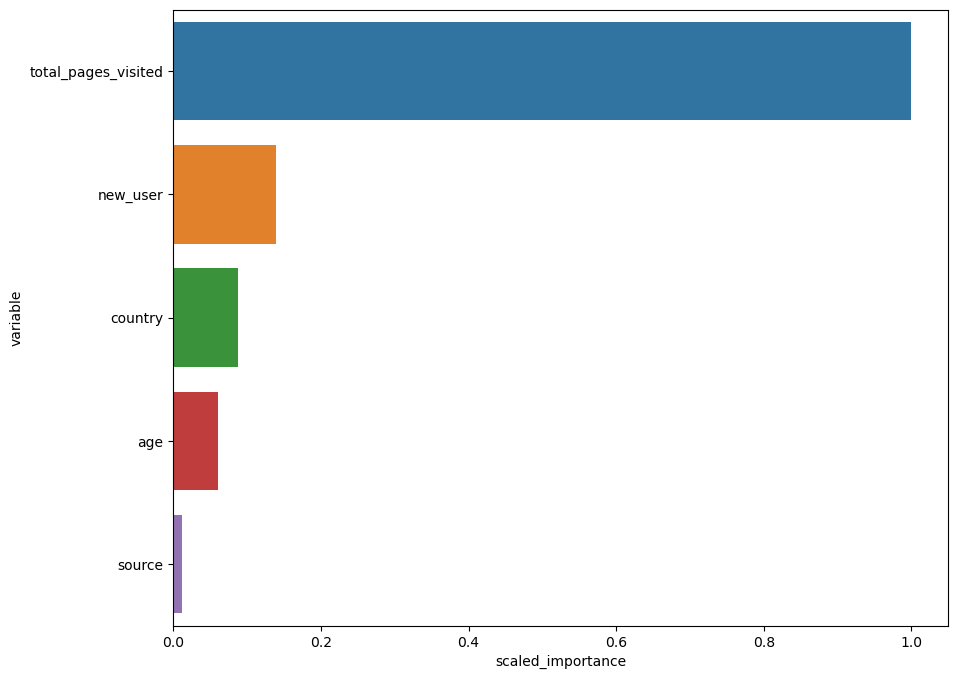

In [7]:
model.varimp_plot()
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

### ROC Curve Comparison

In [10]:
# Make predictions
train_true = train.as_data_frame()['converted'].values
test_true = test.as_data_frame()['converted'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
